In [1]:
import re
import os
import cv2
import time
import random
import plotly.express as px
from tqdm import tqdm
from scipy import signal
import scipy as sp
import scipy.ndimage
import numpy as np
import typing as t
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as k
from scipy.stats import norm, kurtosis
from pandas.plotting import scatter_matrix
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import roc_auc_score
from tensorflow.keras.models import load_model, Model
from joblib import Parallel, delayed
from skimage.transform import resize
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor, CatBoostClassifier

import config as c
from utils.image_processing import crop_image, create_circular_mask, get_height_map, get_circular_std, get_circular_sum, get_circular_kurtosis, get_circular_ratio, get_bright_sum, get_ellipse_coefficient, get_histogram_matrix
from utils.dataset import get_train_data, get_test_data, get_private_test_data

plt.rcParams["figure.figsize"] = (10, 10)

## Загружаем данные для обучения

In [2]:
df = get_train_data(available_energy_values=[1, 3, 6, 10, 20, 30], input_shape=(80, 80), values_linear_transformation=False, center_by_max=False, short_load=False, distance_matrices=False, return_as_dataframe=True)

100%|██████████| 6758/6758 [00:00<00:00, 25892.75it/s]


## Отфильтровываем смещенные пятна и генерируем фичи

In [3]:
df_center_shifted = df[((df.circular_ratio<0.8)&(df.bright_sum>5))]
df = df[~((df.circular_ratio<0.8)&(df.bright_sum>5))]

df['img_80'] = df['img_80'].map(lambda img: img-np.mean((img[:25]+img[-25:]), axis=0).reshape(1, 80)/2+100.4)

df['circular_std'] = Parallel(n_jobs=c.NUM_CORES)(delayed(get_circular_std)(img) for img in tqdm(df['img_80']))
df['circular_sum'] = Parallel(n_jobs=c.NUM_CORES)(delayed(get_circular_sum)(img) for img in tqdm(df['img_80']))
df['circular_kurtosis'] = Parallel(n_jobs=c.NUM_CORES)(delayed(get_circular_kurtosis)(img) for img in tqdm(df['img_80']))
df['ellipse_coefficient'] = Parallel(n_jobs=c.NUM_CORES)(delayed(get_ellipse_coefficient)(img) for img in tqdm(df['img_80']))

100%|██████████| 8909/8909 [00:00<00:00, 9487.74it/s]


In [4]:
df.head()

,t,e,circular_ratio,bright_sum,img_80,circular_std,circular_sum,circular_kurtosis,ellipse_coefficient
0,1,1,0.088028,2.457998,"[[100.1, 97.62, 101.4, 107.92, 101.0, 103.24, ...",40.117092,126840.476562,-1.556179,0.000000
1,1,1,0.009804,2.204998,"[[93.04, 105.14, 104.98, 99.520004, 99.14, 104...",40.101467,126793.382812,-1.307756,0.000000
2,1,20,0.895706,11.694000,"[[101.74, 101.1, 100.1, 97.880005, 100.74, 101...",43.719410,137182.718750,-1.396322,0.556596
3,1,6,0.889908,3.701998,"[[98.58, 100.66, 98.880005, 96.98, 101.22, 97....",40.605701,128325.453125,-1.368323,0.000000
4,1,20,0.895706,10.663999,"[[101.74, 104.08, 99.94, 95.28, 97.48, 97.58, ...",43.433891,136451.328125,-1.400491,0.529227


## Формируем усредненную матрицу гистограмм для каждой частицы и ищем расхождение между ней и гистограммами частиц

In [5]:
df['hist_matrix'] = Parallel(n_jobs=c.NUM_CORES)(delayed(get_histogram_matrix)(img, 16) for img in tqdm(df['img_80']))

mean_hist_matrix = []
for e in [3, 10]:
    mean_hist_matrix.append(np.mean(df[(df.t==0)&(df.e==e)]['hist_matrix']))
    
for e in [1, 6, 20]:
    mean_hist_matrix.append(np.mean(df[(df.t==1)&(df.e==e)]['hist_matrix']))
    
mean_hist_matrix = np.array(mean_hist_matrix)

for i in range(len(mean_hist_matrix)):
    df['error_'+str(i)] = Parallel(n_jobs=c.NUM_CORES)(delayed(mean_absolute_error)(mean_hist_matrix[i], hist_matrix) for hist_matrix in df['hist_matrix'])

100%|██████████| 8909/8909 [00:01<00:00, 4647.36it/s]


### Scatter matrix

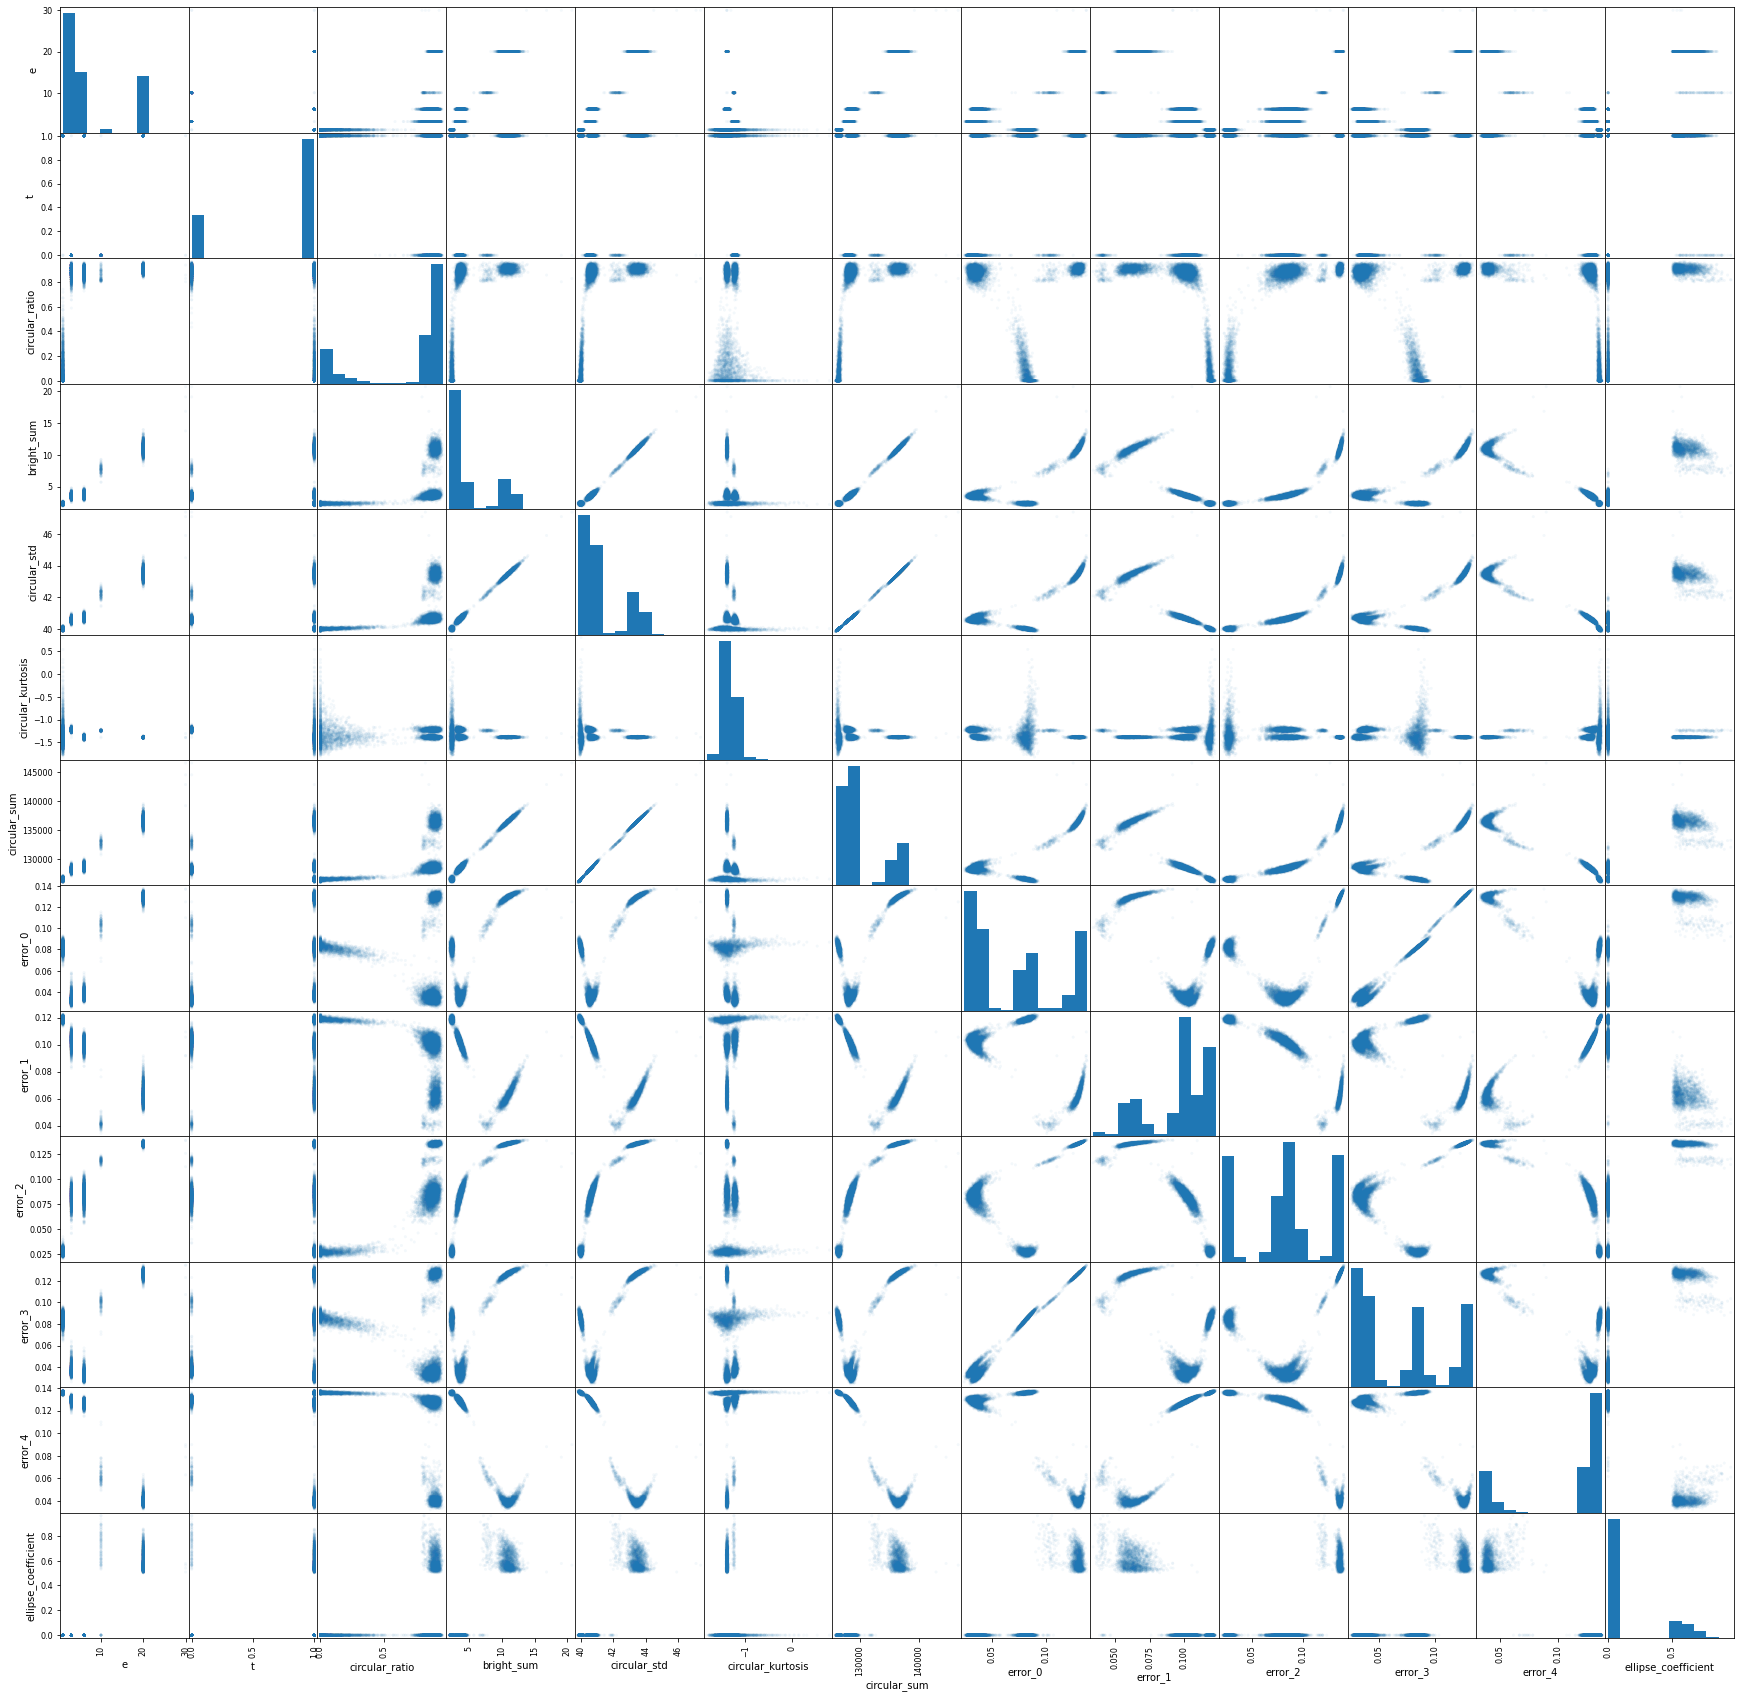

In [6]:
scatter_matrix(df[['e', 't', 'circular_ratio', 'bright_sum', 'circular_std', 'circular_kurtosis', 'circular_sum', 'error_0', 'error_1', 'error_2', 'error_3', 'error_4', 'ellipse_coefficient']], alpha=0.05, figsize=(30, 30));

In [7]:
df.head()

,t,e,circular_ratio,bright_sum,img_80,circular_std,circular_sum,circular_kurtosis,ellipse_coefficient,hist_matrix,error_0,error_1,error_2,error_3,error_4
0,1,1,0.088028,2.457998,"[[100.1, 97.62, 101.4, 107.92, 101.0, 103.24, ...",40.117092,126840.476562,-1.556179,0.000000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.082468,0.118320,0.028867,0.084458,0.134906
1,1,1,0.009804,2.204998,"[[93.04, 105.14, 104.98, 99.520004, 99.14, 104...",40.101467,126793.382812,-1.307756,0.000000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.078849,0.119419,0.029845,0.080030,0.136097
2,1,20,0.895706,11.694000,"[[101.74, 101.1, 100.1, 97.880005, 100.74, 101...",43.719410,137182.718750,-1.396322,0.556596,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.132114,0.068321,0.136251,0.129762,0.039316
3,1,6,0.889908,3.701998,"[[98.58, 100.66, 98.880005, 96.98, 101.22, 97....",40.605701,128325.453125,-1.368323,0.000000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.034932,0.102813,0.082102,0.030629,0.128451
4,1,20,0.895706,10.663999,"[[101.74, 104.08, 99.94, 95.28, 97.48, 97.58, ...",43.433891,136451.328125,-1.400491,0.529227,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.129646,0.060917,0.135954,0.127263,0.037500


# <------------------------------------------------------------------------------------------------------------------------------------------------------------------------------->


# Обучение модели на классификацию ER3 и NR6, подходит так-же для (ER1/NR3) и (ER6/NR10)

In [40]:
df_ = df[(df.t==0)&(df.e==3) | (df.t==1)&(df.e==6)]

x = df_[['bright_sum', 'circular_ratio', 'circular_std', 'circular_kurtosis', 'circular_sum', 'error_0', 'error_1', 'error_2', 'error_3', 'error_4', 'ellipse_coefficient']].to_numpy()
y = df_.t.to_numpy().reshape(-1, 1)
print(len(x), np.mean(y))
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=41)

4487 0.5001114330287497


#### CatBoostRegressor:

In [41]:
particle_types_model_ER3_NR6 = CatBoostRegressor(iterations=150,
                          learning_rate=3e-2,
                          l2_leaf_reg=1.0,  # any pos value
                          depth=6,  # int up to 16
                          min_data_in_leaf=1,  # 1,2,3,4,5
                          rsm=1,  # 0.01 .. 1.0
                          langevin=False,
                          task_type="GPU",
                          devices='0:1')

particle_types_model_ER3_NR6.fit(x_train, y_train, eval_set=(x_test, y_test), verbose=0)
print(roc_auc_score(particle_types_model_ER3_NR6.predict(x_train)>0.5, y_train), roc_auc_score(particle_types_model_ER3_NR6.predict(x_test)>0.5, y_test))

1.0 0.9994413407821229


#### LinearRegression:

In [10]:
particle_types_model_ER3_NR6 = LinearRegression().fit(x_train, y_train)
particle_types_model_ER3_NR6.score(x_train, y_train)


print(roc_auc_score(particle_types_model_ER3_NR6.predict(x_train)>0.5, y_train), roc_auc_score(particle_types_model_ER3_NR6.predict(x_test)>0.5, y_test))

0.9985141085175473 0.9983271260086903


#### GradientBoostingClassifier

In [11]:
from sklearn import ensemble
particle_types_model_ER3_NR6 = ensemble.GradientBoostingClassifier(n_estimators=100, random_state=11)
particle_types_model_ER3_NR6.fit(x_train, y_train.ravel())

print(roc_auc_score(y_train, particle_types_model_ER3_NR6.predict(x_train)>0.5), roc_auc_score(y_test, particle_types_model_ER3_NR6.predict(x_test)>0.5))

1.0 0.9988901220865705


#### Гистограмма ответов модели:

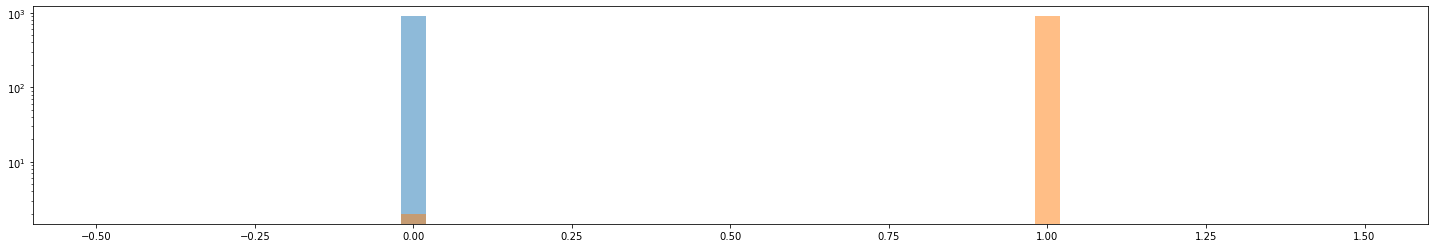

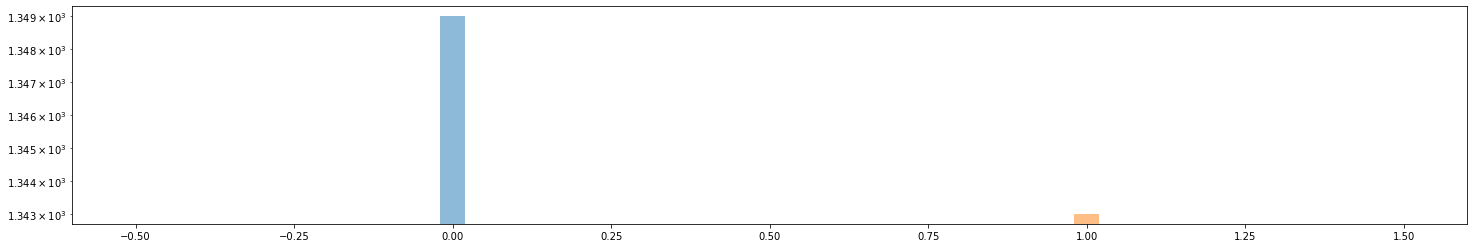

In [12]:
plt.rcParams["figure.figsize"] = (25, 4)
plt.hist(particle_types_model_ER3_NR6.predict(x_test[y_test.reshape(-1)==0]), bins=50, alpha=0.5, range=(-0.5, 1.5), log=True)
plt.hist(particle_types_model_ER3_NR6.predict(x_test[y_test.reshape(-1)==1]), bins=50, alpha=0.5, range=(-0.5, 1.5), log=True)
plt.show()

plt.hist(particle_types_model_ER3_NR6.predict(x_train[y_train.reshape(-1)==0]), bins=50, alpha=0.5, range=(-0.5, 1.5), log=True)
plt.hist(particle_types_model_ER3_NR6.predict(x_train[y_train.reshape(-1)==1]), bins=50, alpha=0.5, range=(-0.5, 1.5), log=True)
plt.show()

#### На каких частицах происходит ошибка:

In [13]:
df_ = df[(df.t==0)&(df.e==3) | (df.t==1)&(df.e==6)]
df_[df_.t!=(particle_types_model_ER3_NR6.predict(x)>0.5)*1].head()

,t,e,circular_ratio,bright_sum,img_80,circular_std,circular_sum,circular_kurtosis,ellipse_coefficient,hist_matrix,error_0,error_1,error_2,error_3,error_4
2272,1,6,0.861446,3.393998,"[[98.44, 100.340004, 99.520004, 93.340004, 97....",40.497616,127990.0000,-1.304313,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.036896,0.107588,0.070816,0.034281,0.131346
5549,1,6,0.889908,3.106998,"[[105.8, 96.3, 99.98, 103.54, 103.94, 98.64, 1...",40.444145,127823.6875,-1.284730,0.0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.040621,0.107305,0.068991,0.039580,0.131844


#### Ошибка на классах, которые в обучении не использовались:

In [14]:
df_ = df[(df.t==0)&(df.e==10) | (df.t==1)&(df.e==10)]

x = df_[['bright_sum', 'circular_ratio', 'circular_std', 'circular_kurtosis', 'circular_sum', 'error_0', 'error_1', 'error_2', 'error_3', 'error_4', 'ellipse_coefficient']].to_numpy()
y = df_.t.to_numpy().reshape(-1, 1)

print(sum(y==0), sum(y==1), roc_auc_score(y, particle_types_model_ER3_NR6.predict(x)>0.5))

[134] [2] 1.0


In [15]:
x = df[['bright_sum', 'circular_ratio', 'circular_std', 'circular_kurtosis', 'circular_sum', 'error_0', 'error_1', 'error_2', 'error_3', 'error_4', 'ellipse_coefficient']].to_numpy()
df['particle_types_predict_ER3_NR6'] = particle_types_model_ER3_NR6.predict(x)

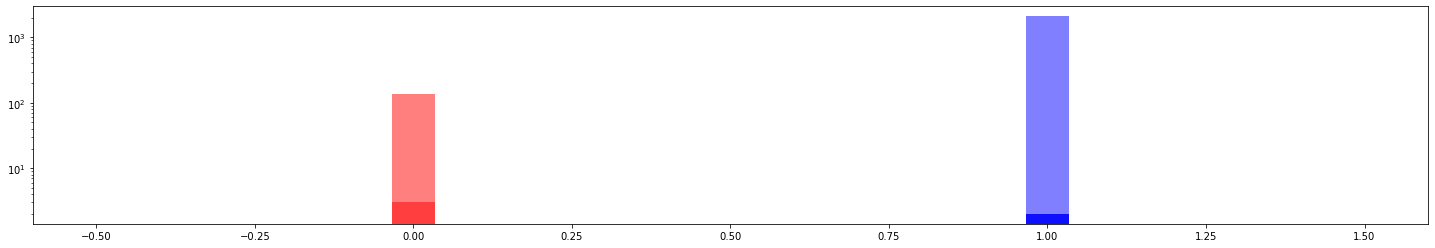

In [16]:
for e in [1, 6, 10, 20]:
    plt.hist(df[(df.e==e)&(df.t==0)].particle_types_predict_ER3_NR6, color='r', alpha=0.5, log=True, range=(-0.5, 1.5), bins=30)
    
for e in [3, 10, 20, 30]:
    plt.hist(df[(df.e==e)&(df.t==1)].particle_types_predict_ER3_NR6, color='b', alpha=0.5, log=True, range=(-0.5, 1.5), bins=30)

# <------------------------------------------------------------------------------------------------------------------------------------------------------------------------------->


# Обучение модели на классификацию ER10 и NR20, подходит так-же для (ER6/NR10) и (ER20/NR30)

In [42]:
df_ = df[(df.t==0)&(df.e==10) | (df.t==1)&(df.e==20)]

x = df_[['bright_sum', 'circular_ratio', 'circular_std', 'circular_kurtosis', 'circular_sum', 'error_0', 'error_1', 'error_2', 'error_3', 'error_4', 'ellipse_coefficient']].to_numpy()
y = df_.t.to_numpy().reshape(-1, 1)
print(len(x), np.mean(y))
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=41)

2239 0.9401518535060295


#### CatBoostRegressor:

In [43]:
particle_types_model_ER10_NR20 = CatBoostRegressor(iterations=150,
                          learning_rate=3e-2,
                          l2_leaf_reg=1.0,  # any pos value
                          depth=6,  # int up to 16
                          min_data_in_leaf=1,  # 1,2,3,4,5
                          rsm=1,  # 0.01 .. 1.0
                          langevin=False,
                          task_type="GPU",
                          devices='0:1')

particle_types_model_ER10_NR20.fit(x_train, y_train, eval_set=(x_test, y_test), verbose=0)
print(roc_auc_score(particle_types_model_ER10_NR20.predict(x_train)>0.5, y_train), roc_auc_score(particle_types_model_ER10_NR20.predict(x_test)>0.5, y_test))

1.0 1.0


#### LinearRegression:

In [19]:
particle_types_model_ER10_NR20 = LinearRegression().fit(x_train, y_train)
particle_types_model_ER10_NR20.score(x_train, y_train)


print(roc_auc_score(particle_types_model_ER10_NR20.predict(x_train)>0.5, y_train), roc_auc_score(particle_types_model_ER10_NR20.predict(x_test)>0.5, y_test))

1.0 1.0


#### GradientBoostingClassifier

In [20]:
from sklearn import ensemble
particle_types_model_ER10_NR20 = ensemble.GradientBoostingClassifier(n_estimators=100, random_state=11)
particle_types_model_ER10_NR20.fit(x_train, y_train.ravel())

print(roc_auc_score(y_train, particle_types_model_ER10_NR20.predict(x_train)>0.5), roc_auc_score(y_test, particle_types_model_ER10_NR20.predict(x_test)>0.5))

1.0 1.0


#### Гистограмма ответов модели:

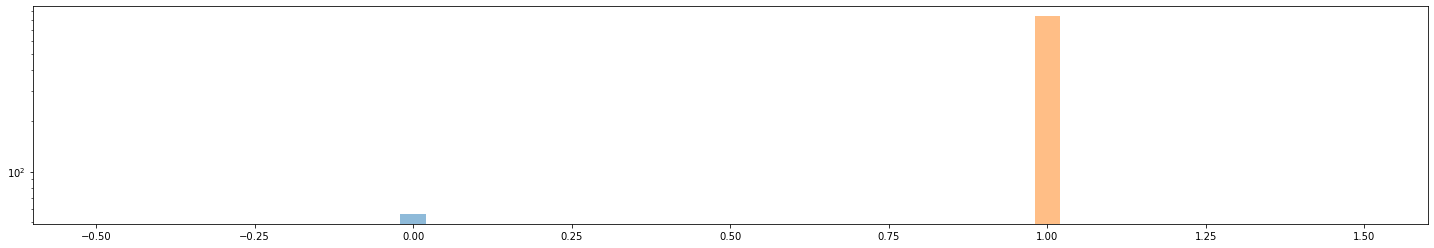

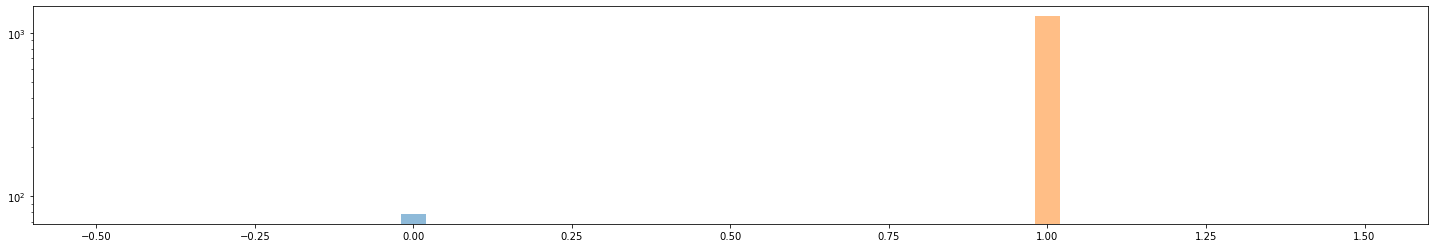

In [21]:
plt.rcParams["figure.figsize"] = (25, 4)
plt.hist(particle_types_model_ER3_NR6.predict(x_test[y_test.reshape(-1)==0]), bins=50, alpha=0.5, range=(-0.5, 1.5), log=True)
plt.hist(particle_types_model_ER3_NR6.predict(x_test[y_test.reshape(-1)==1]), bins=50, alpha=0.5, range=(-0.5, 1.5), log=True)
plt.show()

plt.hist(particle_types_model_ER3_NR6.predict(x_train[y_train.reshape(-1)==0]), bins=50, alpha=0.5, range=(-0.5, 1.5), log=True)
plt.hist(particle_types_model_ER3_NR6.predict(x_train[y_train.reshape(-1)==1]), bins=50, alpha=0.5, range=(-0.5, 1.5), log=True)
plt.show()

#### На каких частицах происходит ошибка:

In [22]:
df_ = df[(df.t==0)&(df.e==10) | (df.t==1)&(df.e==20)]
df_[df_.t!=(particle_types_model_ER3_NR6.predict(x)>0.5)*1].head()

,t,e,circular_ratio,bright_sum,img_80,circular_std,circular_sum,circular_kurtosis,ellipse_coefficient,hist_matrix,error_0,error_1,error_2,error_3,error_4,particle_types_predict_ER3_NR6


#### Ошибка на классах, которые в обучении не использовались:

In [23]:
df_ = df[(df.t==0)&(df.e==30) | (df.t==1)&(df.e==20)]

x = df_[['bright_sum', 'circular_ratio', 'circular_std', 'circular_kurtosis', 'circular_sum', 'error_0', 'error_1', 'error_2', 'error_3', 'error_4', 'ellipse_coefficient']].to_numpy()
y = df_.t.to_numpy().reshape(-1, 1)

print(sum(y==0), sum(y==1), roc_auc_score(y, particle_types_model_ER10_NR20.predict(x)>0.5))

[2] [2105] 0.75


In [24]:
x = df[['bright_sum', 'circular_ratio', 'circular_std', 'circular_kurtosis', 'circular_sum', 'error_0', 'error_1', 'error_2', 'error_3', 'error_4', 'ellipse_coefficient']].to_numpy()
df['particle_types_predict_ER10_NR20'] = particle_types_model_ER10_NR20.predict(x)

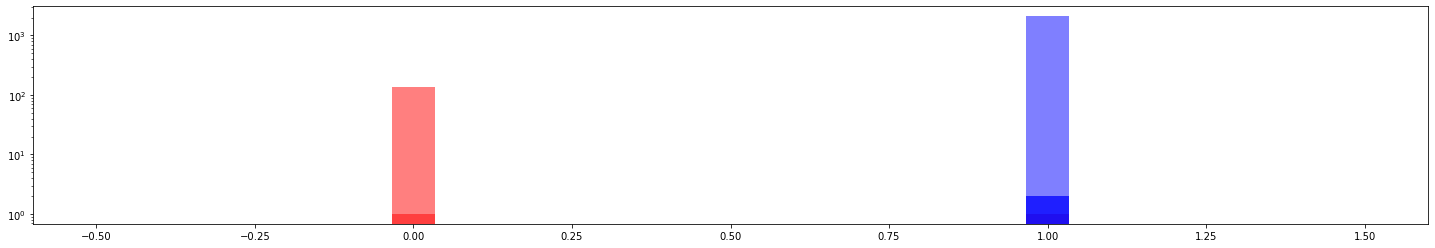

In [25]:
for e in [6, 10, 20, 30]:
    plt.hist(df[(df.e==e)&(df.t==0)].particle_types_predict_ER10_NR20, color='r', alpha=0.5, log=True, range=(-0.5, 1.5), bins=30)
    
for e in [10, 20, 30]:
    plt.hist(df[(df.e==e)&(df.t==1)].particle_types_predict_ER10_NR20, color='b', alpha=0.5, log=True, range=(-0.5, 1.5), bins=30)

# <------------------------------------------------------------------------------------------------------------------------------------------------------------------------------->


# Предсказание приватных данных

In [26]:
df_private = get_private_test_data((80, 80))

100%|██████████| 15058/15058 [00:05<00:00, 2580.63it/s]


## Отфильтровываем смещенные пятна и генерируем фичи

In [27]:
df_private['is_center_shifted'] = ((df_private.circular_ratio<0.8)&(df_private.bright_sum>5))

df_private['img_80'] = df_private['img_80'].map(lambda img: img-np.mean((img[:25]+img[-25:]), axis=0).reshape(1, 80)/2+100.4)

df_private['circular_std'] = Parallel(n_jobs=c.NUM_CORES)(delayed(get_circular_std)(img) for img in tqdm(df_private['img_80']))
df_private['circular_sum'] = Parallel(n_jobs=c.NUM_CORES)(delayed(get_circular_sum)(img) for img in tqdm(df_private['img_80']))
df_private['circular_kurtosis'] = Parallel(n_jobs=c.NUM_CORES)(delayed(get_circular_kurtosis)(img) for img in tqdm(df_private['img_80']))
df_private['ellipse_coefficient'] = Parallel(n_jobs=c.NUM_CORES)(delayed(get_ellipse_coefficient)(img) for img in tqdm(df_private['img_80']))

100%|██████████| 15058/15058 [00:01<00:00, 10167.47it/s]


In [32]:
df_private['hist_matrix'] = Parallel(n_jobs=c.NUM_CORES)(delayed(get_histogram_matrix)(img, 16) for img in tqdm(df_private['img_80']))

for i in range(len(mean_hist_matrix)):
    df_private['error_'+str(i)] = Parallel(n_jobs=c.NUM_CORES)(delayed(mean_absolute_error)(mean_hist_matrix[i], hist_matrix) for hist_matrix in df_private['hist_matrix'])

100%|██████████| 15058/15058 [00:03<00:00, 4432.73it/s]


In [34]:
mask = create_circular_mask(80, 80, radius=8)
df_private['sum'] = df_private['img_80'].map(lambda img: np.sum(img[mask])/np.sum(mask)-100.4)

In [ ]:
df_private.head()

### Выделяем границы

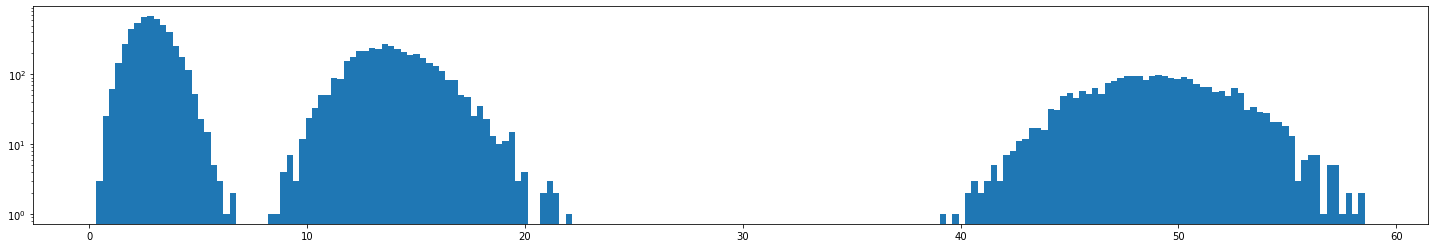

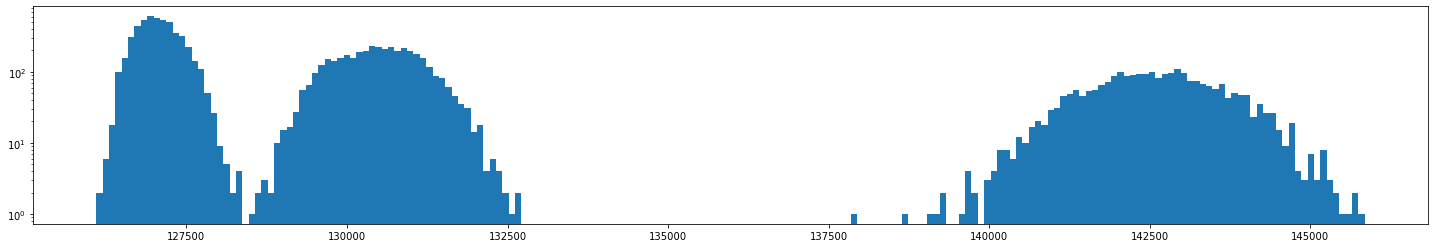

In [35]:
plt.rcParams["figure.figsize"] = (25, 4)

plt.hist(df_private[~df_private['is_center_shifted']]['sum'], bins=200, log=True)
plt.show()

plt.hist(df_private[~df_private['is_center_shifted']]['circular_sum'], bins=200, log=True)
plt.show()

In [50]:
np.sum(df_private[~df_private['is_center_shifted']]['sum']<7.5)

5042

In [51]:
np.sum(df_private[~df_private['is_center_shifted']]['sum']>30)

2522

In [52]:
np.sum((30>df_private[~df_private['is_center_shifted']]['sum'])&(df_private[~df_private['is_center_shifted']]['sum']>7.5))

3925

## Производим классификацию

In [44]:
x = df_private[['bright_sum', 'circular_ratio', 'circular_std', 'circular_kurtosis', 'circular_sum', 'error_0', 'error_1', 'error_2', 'error_3', 'error_4', 'ellipse_coefficient']].to_numpy()
df_private['particle_types_predict_ER10_NR20'] = particle_types_model_ER10_NR20.predict(x)
df_private['particle_types_predict_ER3_NR6'] = particle_types_model_ER3_NR6.predict(x)

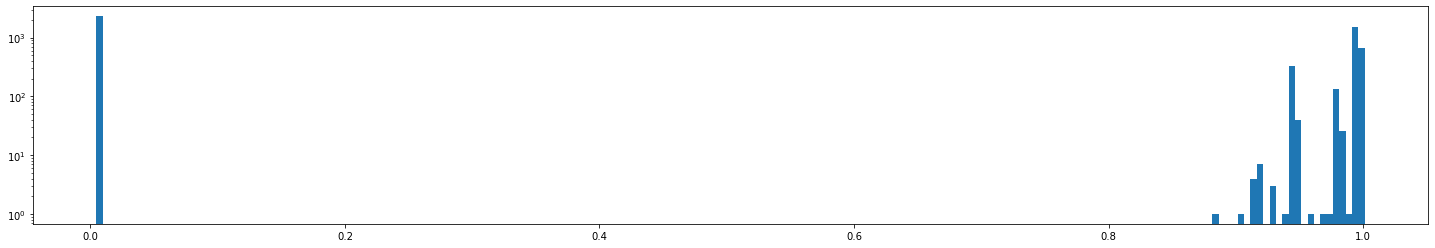

In [45]:
plt.rcParams["figure.figsize"] = (25, 4)

plt.hist(df_private[(~df_private['is_center_shifted'])&(df_private['sum']<7.5)]['particle_types_predict_ER3_NR6'], bins=200, log=True)
plt.show()

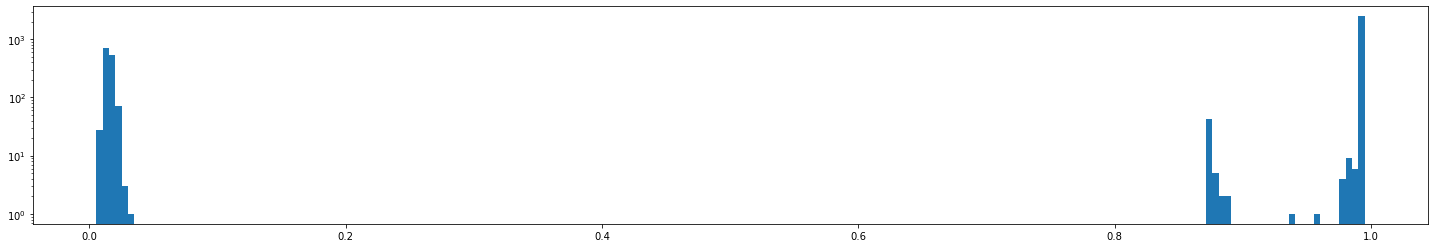

In [46]:
plt.rcParams["figure.figsize"] = (25, 4)

plt.hist(df_private[(~df_private['is_center_shifted'])&(df_private['sum']>7.5)&(df_private['sum']<30)]['particle_types_predict_ER3_NR6'], bins=200, log=True)
plt.show()

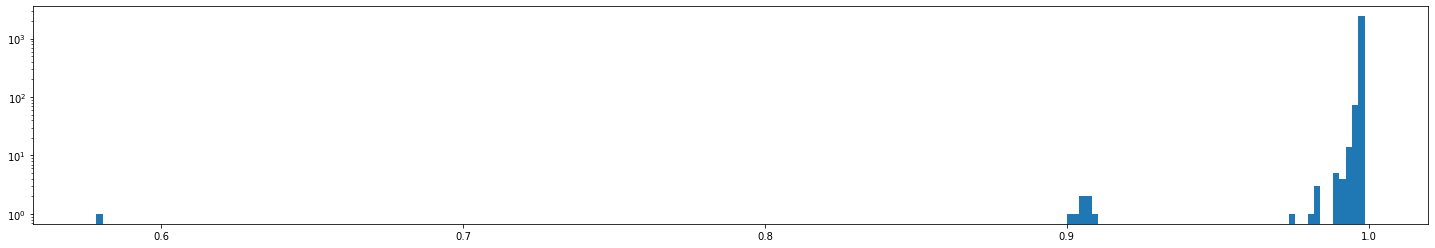

In [47]:
plt.rcParams["figure.figsize"] = (25, 4)

plt.hist(df_private[(~df_private['is_center_shifted'])&(df_private['sum']>30)]['particle_types_predict_ER10_NR20'], bins=200, log=True)
plt.show()

### Меня немного смущают предсказания ниже 0,92 на втором и третьем графике, как-бы они не были результатами ошибки, буду думать, как это иожно проверить. Еще можно попробовать добавить новые модели, но главное следить за переобучением